# concrete.biopython, practical applications

**concrete.biopython** is a **FHE** library based on python [**biopython**](https://biopython.org/) library. It implements the same objects and functions when they are compatible with fhe.

In bioinformatics, the most basic object is the **sequence**. Sequences generally reprensent **DNA** and **RNA** strands, or **proteins** which are **amino acids** strands. Bioinformatics computations are most often processings of such sequences. This tutorial presents some basic processing algorithms on sequences, in **FHE**. Indeed, as data is often very sensitive in bioinformatics, using **FHE** garanties full end to end privacy of the data and of its processing.  

Some applications are inspired from this python bioinformatics [tutorial](https://github.com/mrdbourke/coursera_bioinformatics_and_genetic_algorithm_experiment/blob/master/coursera-bioinformatics-content-and-genetic-algorithm-experiment.ipynb). We will first see how to make reusable code to easily generate circuits than can be used for different applications, then we will see the applications themselves.



## I. Setting up FHE for practical applications

Before presenting the algorithms, we will set up some reusable code that will help us for each application later. Given a sequence processing function and a list biopython <span style="color:green">**Seq**</span> objects, our reusable code should allow to:

**i.** Preprocess the list of sequences so as to convert it into a single integer array that will be the circuit's input.  

**ii.** Generate automatically a circuit adapted to the length of our input and using a given sequence processing function.  

**iii.** Run the circuit and measure performance on given input.

### Imports
First of all, we need to import **numpy** and **concrete.fhe**, as well as <span style="color:green">**Seq**</span>  from **Bio.Seq**.
Then we import <span style="color:orange">**FheSeq**</span> from **concrete_biopython.FheSeq**, and also **SeqWrapper.**<span style="color:#5CC8FF">**SeqWrapper**</span> which will allow to interface the two librairies.

You can check out the quickstart tutorial presenting these objects in more details. Here, we will follow a similar route than in the quickstart to interface **Bio.Seq** and **concrete_biopython.FheSeq** objects.

In [117]:
import numpy as np
import numpy as np
from concrete import fhe
from Bio.Seq import Seq

import sys, os, time
sys.path.append(os.path.dirname(os.getcwd()))

from concrete_biopython.FheSeq import FheSeq
from concrete_biopython.SeqWrapper import SeqWrapper


### i. Sequence preprocessing

As in the quickstart tutorial, we will need to convert <span style="color:green">**Seq**</span> objects from outside FHE to <span style="color:orange">**FheSeq**</span> objects inside the FHE circuit.  

For each practical applications, we will have different numbers of <span style="color:green">**Seq**</span> objects to encrypt and process. In order to be able to reuse our code for these multiple applications, we can merge these sequences into one long sequence, so that our circuit takes only one input sequence every time.

Let's define a `concat_sequences` function that concatenates a list of sequences and returns the concatenated sequence, along with indices to be able to slice concatenated sequence back later. Let's also define the reverse function `slice_sequence` to slice back a long sequence into several sequences:

In [118]:
def concat_sequences(seqs):
    """
    Concatenate sequences from a list and records indices as slice objects
    """
    slices=[]
    seq=Seq('')
    index=0
    for s in seqs:
        seq = seq+s # Seq objects can be directly added
        slices.append(slice(index, index+len(s)))
        index+=len(s)
    return seq, slices

def slice_sequence(seq, slices):
    """
    Slice a sequence into its original sub-sequences
    """
    seqs=[]
    index=0
    for ind in slices:
        seqs.append(seq[ind.start:ind.stop])
    return seqs

# Testing the functions
SEQ, INDICES = concat_sequences([Seq('AB'), Seq('C'), Seq('DEF')])
print(SEQ)
print(slice_sequence(SEQ, INDICES))

ABCDEF
[Seq('AB'), Seq('C'), Seq('DEF')]


### ii. Making a circuit factory

We want to make a circuit factory so that for each application later, we can simply provide a core sequence processing function and provide it to the factory that will generate a circuit from it. We will even wrap this circuit to be able to work with <span style="color:green">**Seq**</span> objects inputs instead of integer arrays inputs.

The core function will be named `process_sequence`, taking a sequence and returning the result of some processing algorithm. We want a function that can work on both clear or encrypted data, so we also provide it with the library **numpy** or **concrete.fhe** for when there are differences in the processing. For now, we define a simple processing function for the example, that outputs wether two sequences are identical. It first slices the input sequence into two sequences, and then compares them.  

Then, let's make a `circuit_factory` returning a circuit compiled on a given sequence processing function, and adapted for a given input sequence: the inputset is adapted to the sequence length and to the letters present in the sequence, which allows faster and more precise FHE computations. Note that the integer array input `data` is first converted into a <span style="color:orange">**FheSeq**</span> objects so that the sequence processing function can work on it the same way it works on <span style="color:green">**Seq**</span> objects:

In [119]:
def process_sequence(seq, lib=fhe):
    """
    Check wether the two first subsequences are identical, for test
    """
    seqlist = slice_sequence(seq, INDICES)
    return seqlist[0]==seqlist[1]

def circuit_factory(seq, process_seq):
    """
    Return a circuit compiled on 'process_seq' with input lenght 'input_lengt'
    """
    compiler = fhe.Compiler(lambda data: process_seq(FheSeq(data)), {"data": "encrypted"})    
    return compiler.compile(
        inputset=[
        # Use SeqWrapper.maxInteger() to know the maximum integer that can be
        # used to represent a character in FheSeq obects
        np.random.randint(0, SeqWrapper.maxInteger()+1, size=(len(seq),))
        for _ in range(300)
        ],
        configuration=fhe.Configuration(
            enable_unsafe_features=True,
            use_insecure_key_cache=True,
            insecure_key_cache_location=".keys",
            dataflow_parallelize=False, # setting it to True makes the jupyter kernel crash
        ),
        verbose=False,
    )

# Test process_sequence
OUTPUT_PYTHON = process_sequence(SEQ, np)
print("Python: Are the first two sequences equal ?: ", OUTPUT_PYTHON)

Python: Are the first two sequences equal ?:  False


### iii. Running the circuit and measuring performance

As we wish to compare the performance of different circuit, we will use the `measure_time` function which will execute a function on given inputs and display the computation time.  

Then, we make a `circuit_wrapper` that allows to run a circuit onto a <span style="color:green">**Seq**</span> object, using the <span style="color:#5CC8FF">**SeqWrapper**</span>**.toIntegers** function. Here, we will need the wrapper to return **integer outputs**, but we could have converted them back into a <span style="color:green">**Seq**</span> object if needed using <span style="color:#5CC8FF">**SeqWrapper**</span>**.toSeq**. We measure and display the times for compiling, encrypting, and running.  

Finally, in order to keep reusing code, we can pack the actual making and running of a circuit in a function, along with printing the output and displaying computation time in `compute_fhe_output`:

In [120]:
def measure_time(function, descripton, *inputs):
    """
    Compute a function on inputs and return output along with duration
    """
    start = time.time()
    output = function(*inputs)
    end = time.time()
    print(f"|  {descripton} : {end-start:.2f} s  |")
    return output

def circuit_wrapper(circuit, seq):
    """
    Wrap a fhe circuit in order to input Bio.Seq objects, and simulate if needed
    """
    # Convert Seq object to integers with SeqWrapper.toIntegers
    integers = SeqWrapper.toIntegers(seq)
    # Run the circuit on integer inputs
    encrypted = measure_time(circuit.encrypt, 'Encrypting', integers)
    run = measure_time(circuit.run,'Running   ', encrypted)
    integer_output = circuit.decrypt(run)
    # Return the integers output
    return integer_output
    # Alternatively, one could return a Seq objects with: return SeqWrapper.toSeq(integer_output)
    
def compute_fhe_output(seq, process_seq, description):
    """
    Pack up the creation and running of a circuit,
    and display the result along with the computation time
    """
    # First print the description and a waiting message
    print(description)
    print("Computing ...", end="", flush=True)
    print("\r", end="")
    
    # Make computations and print output and time
    wrapped_circuit = measure_time(circuit_factory, 'Compiling ', seq, process_seq)
    output_fhe = circuit_wrapper(wrapped_circuit, seq)
    
    print('==> Result :', output_fhe, '\n')

That's it ! Before starting our first practical application, we can try out this code on our test sequence and processing function defined earlier, checking homomorphically wether the two first sequences of the list are identical:

In [121]:
# Compute our simple process_sequence function in FHE on our test sequence:
compute_fhe_output(SEQ, process_sequence, description='FHE: Are the first two sequences equal ?:')

FHE: Are the first two sequences equal ?:
|  Compiling  : 0.34 s  |
|  Encrypting : 0.01 s  |
|  Running    : 0.00 s  |
==> Result : 0 




## II. Computing the distance between two sequences

As a first application, we will compute in FHE the **distance between two sequences**. A distance between two sequences **A** and **B** is a function that measures their similarity and obeys the following conditions:
- If A = B, then *distance(A,B)=0*
- If A ≠ B, then *distance(A,B)>0*
- For all sequences A and B, *distance(A,B) = distance(B,A)*
- For all sequences A,B, and C, *distance(A,C) <= distance(A,B) + distance(B,C)*

Computing the distance between two biological sequences, for instance **DNA** strands, is often used in bioinformatics as a measure of similarity. We will see here the [**hamming distance**](https://en.wikipedia.org/wiki/Hamming_distance) and the [Levenshtein distance](https://en.wikipedia.org/wiki/Levenshtein_distance).

### Hamming distance 
The **hamming distance** between two sequences of **same length** is simply the number of positions where the two sequences are different. It is often used in bioinformatics to measure the similarity of biological sequences of same length such as **DNA** strands.  

Let's define the `hamming` function which computes this distance between two arrays. The `hamming_adapter` allows to adapt inputs from either <span style="color:green">**Seq**</span> or <span style="color:orange">**FheSeq**</span> objects:

In [122]:
def hamming(arr1, arr2):
    """
    Return the number of differences between arrays arr1 and arr2
    """
    if arr1.size != arr2.size:
        raise ValueError('arrays must have same size')
        
    return np.sum(arr1 != arr2)

def hamming_adapter(seq1, seq2, lib=fhe):
    """
    Adapter for hamming distance of Seq objects
    Convert Seq or FheSeq objects into integer arrays
    """
    if lib is fhe:
        return hamming(seq1.toArray(),seq2.toArray())
    else:
        return hamming(np.array(list(str(seq1))), np.array(list(str(seq2))))

Let's measure the distance between two short strands of **DNA**, both in python and FHE:

In [123]:
S = Seq("AGGTTGGTAAAATGGTCCGTGGC")
T = Seq("ACCGTAATAAACGTGTCCGTTGG")

SEQ_H, INDICES_H = concat_sequences([S,T])

def process_sequence(seq, lib=fhe):
    seqlist = slice_sequence(seq, INDICES_H)
    return hamming_adapter(seqlist[0],seqlist[1], lib)

# run the circuit in python
OUTPUT_PYTHON = process_sequence(SEQ_H, np)
print('Python: Haming distance of S & T:', OUTPUT_PYTHON)

# run the circuit in FHE and compare the results
compute_fhe_output(SEQ_H, process_sequence, description='FHE: Haming distance of S & T:')


Python: Haming distance of S & T: 10
FHE: Haming distance of S & T:
|  Compiling  : 0.42 s  |
|  Encrypting : 0.19 s  |


|  Running    : 2.26 s  |
==> Result : 10 



The distance is relatively fast to compute in FHE because it is a simple algorithm.

### Levenshtein distance

The **Levenshtein distance** between two sequences is a bit more complex to compute. It measures **the number of simple operations** needed to transform a sequence into another one. These three simple operations are the **deletion** of an element, the **addition** of an element, and the **swapping** of two different elements. Check out the pseudo-code algorithm at: [Levenshtein distance](https://en.wikipedia.org/wiki/Levenshtein_distance).

This distance is also sometimes used in bioinformatics to measure the similarity of biological sequences with different length.

Again, we define the `levenshtein` function in a recursive fashion (the recursion is in python, but the compiled graph will not be recursive in FHE), as well as a `levenshtein_adapter` to adapt inputs. Note that in `levenshtein` function, we use an **if** condition. While this is forbidden in FHE on encrypted variables, in this case the condition is allowed because it concerns the size of the arrays which is not encrypted.  

However, contrary to the original algorithm where the condition `(arr1[0] == arr2[0])` will stop the computation of the corresponding recursion branch if it is true, the FHE algorithm needs to run both branches of the computation. Indeed, the result of the condition being encrypted, both branches will run which will greatly slow the computation.

In [124]:
def min_two(x, y):
    """
    Return the minimum between a and b
    Note: Using fhe.univariate instead of a boolean multiplication is faster
    """    
    diff = y - x
    min_xy = y - fhe.univariate(lambda x: 0 if x < 0 else x)(diff)
    return min_xy

def min_three(a, b, c):
    return min_two(a,min_two(b,c))

def levenshtein(arr1, arr2):
    """
    Compute the Levenshtein distance between two array objects
    """
    if arr2.size == 0:
        return fhe.ones(1)[0]*arr1.size
    elif arr1.size == 0:
        return fhe.ones(1)[0]*arr2.size
    else:
        iseq0 = (arr1[0] == arr2[0])
        lev1 = levenshtein(arr1[1:], arr2[1:])
        lev2 = levenshtein(arr1[1:], arr2)
        lev3 = levenshtein(arr1, arr2[1:])
        minlev = min_three(lev1, lev2, lev3)
        return iseq0*lev1 + (1-iseq0)*(1+minlev)

def levenshtein_adapter(seq1, seq2, lib=fhe):
    """
    Adapter for levenshtein distance of sequence objects
    Convert Seq or FheSeq objects into integer arrays
    """
    if lib is fhe:
        return levenshtein(seq1.toArray(),seq2.toArray())
    else:
        return levenshtein(np.array(list(str(seq1))), np.array(list(str(seq2))))
    
S = Seq("ACGT")
T = Seq("CGTA")

SEQ_L, INDICES_L = concat_sequences([S,T])

def process_sequence(seq, lib=fhe):
    seqlist = slice_sequence(seq, INDICES_L)
    return levenshtein_adapter(seqlist[0],seqlist[1], lib)

OUTPUT_PYTHON = process_sequence(SEQ_L, np)
print('Python: Levenshtein distance of S & T:', OUTPUT_PYTHON)

Python: Levenshtein distance of S & T: 2


Let's test this distance on very small DNA strands inputs:

In [125]:
compute_fhe_output(SEQ_L, process_sequence, description='FHE: Levenshtein distance of S & T:')

FHE: Levenshtein distance of S & T:
|  Compiling  : 14.23 s  |
|  Encrypting : 0.16 s  |


|  Running    : 9.64 s  |
==> Result : 2 



The computation is relatively quite **long**, and it is sometimes even **wrong** ! Why is that ?  

The function is quite complex compared to the hamming distance, and also it requires to run all conditional branches in the recursive computation. So, it takes a lot of time. But why is the result wrong sometimes ?  

Recall that we did earlier in `circuit_factory`:
```python
inputset=[
    np.random.randint(0, SeqWrapper.maxInteger()+1, size=(len(seq),))
    for _ in range(100)
],
```
This inputset is built randomly. It seems to be not precise enough for our levenshtein algorithm. Let us see different ways to correct this:

- Increasing the size of the input set with more value, with for instance `range(300)` instead. However, this would make the graph creation even slower.  

- Making the inputset more precise, by providing only inputs that will actually be used. In our case, we are working on DNA sequences, so we don't need the inputset to contain other letters such as protein letters. We can specify the exact inputs that will be used:
```python
inputset=[
    np.random.choice( list(set(SeqWrapper.toIntegers(seq))), size=(len(seq),))
    for _ in range(100)
],
```
This works, because here we create a new circuit for every different sequence `seq`. However, in a general case, we would like a circuit working for different sequences, some that may contain other characters than those in seq. Also, it is not optimal because the circuit may be working with integers bigger than necessary.  

- Specifying to the class <span style="color:#5CC8FF">**SeqWrapper**</span> what alphabet we will be using in our sequences with <span style="color:#5CC8FF">**SeqWrapper**</span>**.setAlphabet**. This will optimize the integer representation to work only for the provided letters. In our case, we want to work only with **DNA** upper case letters:

In [126]:
# Reduce the alphabet to DNA uppercase letters
SeqWrapper.setAlphabet('ACGTU')

# Let's run the computation again (the SeqWrapper.maxInteger will be changed in circuit_factory ):
compute_fhe_output(SEQ_L, process_sequence, description='FHE: Levenshtein distance of S & T:')

# Reset alphabet
SeqWrapper.resetAlphabet()

FHE: Levenshtein distance of S & T:
|  Compiling  : 13.76 s  |
|  Encrypting : 0.10 s  |
|  Running    : 2.47 s  |
==> Result : 2 



As we can see, the results are good now, and the running time is smaller. Be aware than setting an alphabet with <span style="color:#5CC8FF">**SeqWrapper**</span>**.setAlphabet** will affect the <span style="color:orange">**FheSeq**</span> internal representation which also uses the class <span style="color:#5CC8FF">**SeqWrapper**</span>, so if the new alphabet does not include protein letters for instance, the <span style="color:orange">**FheSeq**</span>.**translate** function will raise an error.


## II. Finding the origin of replication in a sequence

As a second application, we will look in FHE for the [**origin of replication**](https://en.wikipedia.org/wiki/Origin_of_replication) in a DNA strand. The **origin of replication** (also called the **replication origin**) is a particular sequence in a genome at which **replication** is initiated, used when a cell divides. This area of the genome sometimes needs to be analyzed, but it needs to be found first.  

In most area of DNA genomes, there is an equal proportion of nucleotides **'A'** (adenine), **'C'** (cytosine), **'G'** (guanine) and **'T'** (thymine). However, around the **origin of replication**, the proportion of guanine and thymine (G and T) **is greater** than the proportion of adenine and cytosine (A et C). This particularity is helpful to find the approximate localisation of the origin of replication.  

In the function `minimum_skew` we take a look at the ratio between letter 'G' to letter 'C', to retrieve the location in the strand where this ratio is minimal. To that extent, we first create a lookup table to map letters 'G' to a 1 and letters 'C' to a -1, the other letters 'A' and 'T' being mapped to 0. Then, we sum up the values throughout the sequences, and keep the first index of the minimum value of this cumulated sum. We also return the whole cumulated sum array for plotting.

In [97]:
def minimum_skew(seq,lib=fhe):
    """
    Return the index of the minimum skew in a sequence
    Note: Only the first index of minimum skew is returned
    """ 
    # First, create a lookup table to map G to 1 and C to -1
    if lib is fhe:
        CG_integers = SeqWrapper.toIntegers(Seq('CG'))
        letter_table = [0]*(SeqWrapper.maxInteger()+1)
        letter_table[CG_integers[0]]=-1
        letter_table[CG_integers[1]]=1
        letter_table = fhe.LookupTable(letter_table)
        skew_counts = fhe.zeros(len(seq))
    else:
        letter_table = {'A':0, 'C':-1, 'G':1, 'T':0}
        skew_counts = np.zeros(len(seq)).astype('int')
    
    # Then compute the cumulated sum and keep the first index of the minimum
    skew_counts[0] = letter_table[seq[0]]
    minimum = skew_counts[0]
    min_index = 0
    for i in range(1,len(seq)):
        # Compute cumulated sum
        skew_counts[i] = skew_counts[i-1] + letter_table[seq[i]]
        # and keep minimum
        ismin = (skew_counts[i]<minimum)
        minimum = min_two(skew_counts[i], minimum)
        min_index = i*ismin + min_index*(1-ismin)
        
    return min_index, skew_counts


As mentioned, the function will only output the first index where the minimum value is reached. This is a limitation of FHE. It is indeed not possible to retrieve an arbitrary number of locations in FHE, for instance to return a list with all indices where the minimum is reached. We could however return an array of the size of the sequence containing ones where the minimum is reached, or, with very extensive computations, containing the indices of the minimum followed by zeros.  

Let's test our function on a clear sequence, and plot the cumulated sum of 'C' letters minus 'G' letters. Then we test it with encrypted data:

Python: The minimum skew is at index: 18


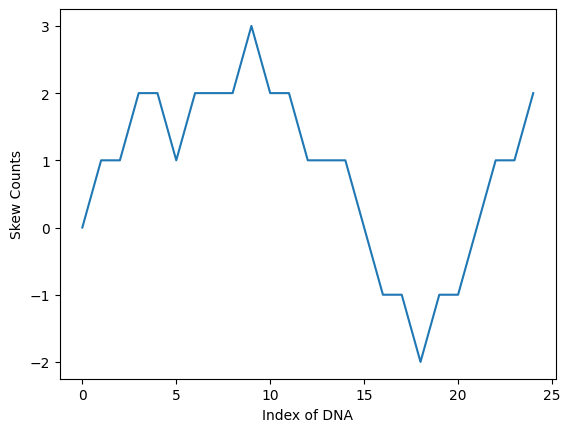

In [99]:
SEQ_O = Seq('AGTGACGTAGCACATCCACGAGGTG')

OUTPUT_PYTHON, skew_counts = minimum_skew(SEQ_O, np)
print('Python: The minimum skew is at index:', OUTPUT_PYTHON)

# Plot the skew_counts to check them out
import matplotlib.pyplot as plt
plt.plot(skew_counts)
plt.ylabel('Skew Counts')
_=plt.xlabel('Index of DNA')


In [100]:
def process_sequence(seq, lib=fhe):
    return minimum_skew(seq, lib)[0] # return only the minimum value for fhe

compute_fhe_output(SEQ_O, process_sequence, description='FHE: The minimum skew is at index:')

FHE, simulated: The minimum skew is at index:
|  Compiling  : 2.57 s  |
|  Encrypting : 0.39 s  |


|  Running    : 18.84 s  |
==> Result : 18 



## III. Sorting sequences

### Comparing two sequences:

As we already saw, <span style="color:green">**Seq**</span> and <span style="color:orange">**FheSeq**</span> classes implement some operators such as **len(**seq**)**, seq**[i:j]**,  or s1**==**s2. They also implement the comparison operators s1 **>** s2, s1 **>=** s2 and their opposite s1 **<** s2, s1 **<=** s2.  

For the <span style="color:green">**Seq**</span> class, a sequence **A** is lower than another sequence **B** (noted *A<B*) if **A** is alphabetically lower than **B** (and not equal to B). The first character is compared first:  
- If *A[0] < B[0]* then *A < B*
- Else, if *A[0] > B[0]* then *A > B*
- Else, *A[0] = B[0]*, so the second character is compared, and so on.  

For instance, `Seq('AB')` is lower than `Seq('AC')`. Also, `Seq('AA')` is lower than the `Seq('AAA')` because the empty character at the end is considered alphabetically lower than all other characters. The <span style="color:orange">**HfeSeq**</span> class works with the same principle.

### Ranking a list of sequences:
With such comparison operators, we are able to sort a list of sequences. On clear data, it is possible to use `sorted(sequence_list)` to sort a list of sequences, but in FHE, this is impossible. Indeed, `sorted()` uses **if** conditions to order the sequences in a new **list** object. In FHE, because **if** conditions are forbidden, we cannot create a new ordered list. However, we can create an array where each index contains the rank of the sequence at this index.  

To do so, we can build a comparison matrix. Suppose our list of sequences is the following : `seqlist = ['CAA', 'AAB', 'CAA', 'AA', 'AAA']`, and we want an ascending ranking. In our comparison matrix, we will compute `comp_matrix[i,j] = seqlist[i]<seqlist[j]` when `i<j`(upper half), and `seqlist[i]>=seqlist[j]` equal to `1-comp_matrix[i,j]` when `j<i` (lower half).  

Then, we can sum up the results on each row to get how many other sequences are lower than the sequence of the row, which gives exactly the ranking of this sequence in the list. Note that even though two identical sequences are provided, they get each a different rank, which is preferable (this is because we used `seqlist[i]>=seqlist[j]` instead of `seqlist[i]>seqlist[j]`).

<div>
<img src="https://rcd-media.com/docs/fhe/tableau_sort.png" width="750"/>
</div>

In [103]:
def sort_rank(seqlist, lib=fhe, ascending=True):
    """
    Returns an array with the rank of each sequence in the list
    """
    n=len(seqlist)
    # Create a comparison matrix
    comp_matrix = lib.zeros((n,n))
    # Fill the matrix with comparison results
    for i in range(0, n):
        for j in range(i+1, n):
            # Compute upper half of the matrix with seqlist[i]<seqlist[j]
            if ascending:
                comp_matrix[i,j] = (seqlist[i]<seqlist[j])
            else:
                comp_matrix[i,j] = (seqlist[i]>=seqlist[j])
                
            # Then fill the contrary to the lower half 
            comp_matrix[j,i] = 1-comp_matrix[i,j]
            # Note: 1-comp_matrix[i,j] is the same as seqlist[j]>=seqlist[i] (for ascending)
            # Using seqlist[j]>=seqlist[i] instead of seqlist[j]>seqlist[i]
            # will return a clear order, with different ranks even for
            # equal sequences. Also, this is faster.
            
    # now sum up each row to get a sorting rank for the sequences
    return np.sum(comp_matrix, axis=0)
            
     
def process_sequence(seq, lib=fhe):
    seqlist = slice_sequence(seq, INDICES_S)
    return sort_rank(seqlist, lib)

Let's test this algorithm on the example sequence list:

In [106]:
# Test the sequence list of the example
SEQ1 = Seq('AA')
SEQ2 = Seq('AAA') # as mentioned earlier, SEQ2 is alphabetically greater than SEQ1
SEQ3 = Seq('AAB')
SEQ4 = Seq('CAA')
SEQ5 = Seq('CAA') # same a SEQ4, will be ranked after it

# Create a shuffled list, like in the example
seqlist = [SEQ5, SEQ3, SEQ4, SEQ1, SEQ2]

# Test sorted in python to compare (remember this cannot work in fhe):
print('Sorted list:', sorted(seqlist))

# Concatenate the list
SEQ_S, INDICES_S = concat_sequences(seqlist)

# Test our algorithm in python
OUTPUT_PYTHON = process_sequence(SEQ_S, np)
print("\nThe ranks of sequences are :", OUTPUT_PYTHON)

Sorted list: [Seq('AA'), Seq('AAA'), Seq('AAB'), Seq('CAA'), Seq('CAA')]

The sorted indices of sequences are : [4. 2. 3. 0. 1.]


In [107]:
compute_fhe_output(SEQ_S, process_sequence, description='FHE: The ranks of sequences are:')

The sorted indices of sequences are:
|  Compiling  : 2.64 s  |
|  Encrypting : 0.20 s  |


|  Running    : 7.50 s  |
==> Result : [4 2 3 0 1] 



In [108]:
# also test on a limited alphabet to compare
SeqWrapper.setAlphabet('ABCDEFG')
compute_fhe_output(SEQ_S, process_sequence, description='The ranks of sequences are:')
SeqWrapper.resetAlphabet()

The sorted indices of sequences are:
|  Compiling  : 1.89 s  |
|  Encrypting : 0.10 s  |
|  Running    : 1.05 s  |
==> Result : [4 2 3 0 1] 



Much faster !